# ULTA Revenue Prediction
## Executive Summary
_______

Based on the prediction of the time series analysis model - ARIMA and ULTA beauty's historical data, the prediction for the next five quarters' revenue of ULTA is presented as follows

|   Date   |      Revenue      |
|----------|-------------------|
|2019 Q4 |\$1.75B|
|2020 Q1 |\$2.36B|
|2020 Q2 |\$1.96B|
|2020 Q3 |\$1.87B|
|2020 Q4 |\$1.98B|

As you can see from this table, the next quarter of ULTA would be starting from 10/31/2019, and the estimated revenue for ULTA's next quarter would be 1.751 Billion dollars. In order to reach this conclusion, my analysis has been sequentially divided into four steps. They are, data preprocessing, time series analysis, parameter selection for the time series model, and finally, forecasting using the time series model. Each of these steps would be expanded and explained in details. 

Here is a more visual representation of my prediction. The blue curve is the historical data of ULTA's revenue, and the orange curve is my forecasting about ULTA's next quarters' revenue up until 2021
<img src="final_prediction.png">

## Step 0: Import Libraries 
___

Before we start to do the actually analysis, we need to make sure that our jupyter notebook is equipped with all the necessary analytics tools, i.e. pandas, numpy. pmdarima etc. 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings("ignore")
import itertools
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 10,8

## Step 1: Data Preprocessing
_____

The ULTA revenue data has been sourced from a financial website called [Ycharts](https://ycharts.com). You can get access to ULTA's revenue data through this clickable [link](https://ycharts.com/companies/ULTA/revenues). The very first step of this analysis involves sourcing and cleaning the data. 

I used web-scraping to parse all the revenue data and then proceeded to clean the parsed data. There are basically two columns for this table, year and revenue. Since both columns are in string format, I need to convert year into a python datetime object and convert revenue into floating numbers. 

Finally, I need to determine whether the revenue string ends with a B or M (B stands for Billion and M stands for Million). Therefore, I need to standardize all the numbers into the same scale. In this case, I chose Billion.

In [2]:
data_raw = pd.read_csv('./ULTA-quarterly.csv',header=0)
data_raw.head()

,year,revenue
0,31-Jul-19,1.667B
1,30-Apr-19,1.743B
2,31-Jan-19,2.125B
3,31-Oct-18,1.560B
4,31-Jul-18,1.488B


In [3]:
def format_time(time):
    return datetime.strptime(time, '%d-%b-%y')

def parse_revenue(rev):
    if rev[-1] == 'B':
        return float(rev[:-1])
    if rev[-1] == 'M':
        return float(rev[:-1])/(10**3)
    return 0

data_raw['year_cleaned'] = data_raw['year'].apply(format_time)
data_raw['revenue_cleaned'] = data_raw['revenue'].apply(parse_revenue)
data_cleaned = data_raw[['year_cleaned', 
                         'revenue_cleaned']]\
                    .rename(columns={'year_cleaned':'date',
                                    'revenue_cleaned':'revenue'})
data_cleaned.head()

,date,revenue
0,2019-07-31,1.667
1,2019-04-30,1.743
2,2019-01-31,2.125
3,2018-10-31,1.560
4,2018-07-31,1.488


## Step 2: Time Series Analysis 
____
After the data has been cleaned into a standardized format, I can start to do some exploratory data analysis. I noticed that the data is basically a time series, thus it would be reasonable to plot the time series. From the first figure below, you can start to see that the historical revenue data of ULTA follows a very particular pattern. 

The historical revenue data always shows a great spike in the first quarter and then drops down dramatically in next following quarters. This cycle repeats and become augmented as time goes on. The total revenue of UTLA in 2006 is about 0.68 billion dollars, and in 2018 the total revenue became about 6.53 billion dollars, which is roughly 10 times increase.

After seeing this very clear pattern, the next thing is to decompose the time series and try to capture the trend of the data. By using the seasonal decomposition technique, we are assuming that the observed data follows the mathematical formula: $y_t = trend \times seasonality \times noise$, because from observation, the frequency (width of the cycles) and the amplitude (height of the cycles) are not the same. Therefore, we are assuming that the trend would be non-linear. 

From the second graph below, we can see that the non-linear assumption works quite well as the residuals are very small. We can also see that the trend line follows a non-linear curve, which basically means that it has an increasing or decreasing frequency and/or amplitude over time. 

Text(0, 0.5, 'Revenue (billion $)')

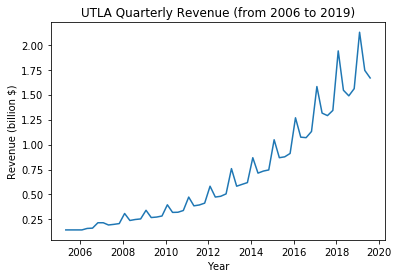

In [4]:
plt.plot(data_cleaned.date, data_cleaned.revenue)
plt.title('UTLA Quarterly Revenue (from 2006 to 2019)')
plt.xlabel('Year')
plt.ylabel('Revenue (billion $)')

In [5]:
rev_2006 = data_cleaned.query('date > 2006 and date < 2007')\
                       .revenue\
                       .sum()
rev_2018 = data_cleaned.query('date > 2018 and date < 2019')\
                       .revenue\
                       .sum()

print(f'revenue in 2006: {rev_2006} billion dollars, revenue in 2018: {rev_2018} billion dollars')

revenue in 2006: 0.6833400000000001 billion dollars, revenue in 2018: 6.53 billion dollars


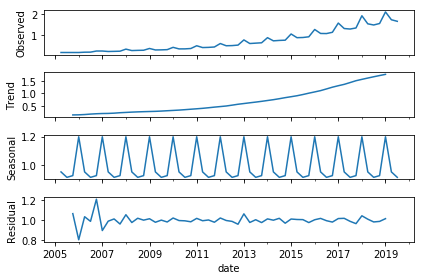

In [6]:
rev = data_cleaned.set_index('date')\
                  .sort_values(by='date')
decomp = sm.tsa.seasonal_decompose(rev, model='multiplicative')
fig = decomp.plot()
plt.show()

## Step 3: Hyper-parameter Tuning for ARIMA Time Series Model
___

After gaining a decent understanding of the time series data, we need to find a model that could learn from the historical data and forecast future revenue. Since the pattern for the revenue is very clear, it is suitable in this case to use the ARIMA model, widely known as AutoRegressive Integrated Moving Average. I would not get into too deep about this model, however, we have three terms that we are going to optimize.

These terms are:
- p: the number of lag observations included in the model, also known as lag order
- d: the number of times the raw observations are differenced, also called the degree of differencing 
- q: the size of the moving average window, also called the order of moving average

In order to accomplish this optimization task, we will need to do a grid search to find the best combination of p, d and q. Meanwhile, we need to split our data into train and test data set. The train data will be used to fit our model, and we would use the test data to validate our model. After the best model is found, we need to fit the model with our train data. And use the trained ARIMA model to make predictions on the dates in the test data set. After the predictions are made, we can compare the predicted revenue and the actual revenue in the test data set to evaluate our model. 

As you can see in the first two graphs below, the predicted revenue curve closely follows the actual revenue curve, which means that our prediction is very accurate and realistic. Furthermore, to give a quantified evaluation for our model, we can use MSE (mean squared error) to capture how accurate our model is. The MSE for our model is about 0.0045, indicating that our model did have a significant predicative power. 

Finally, we can plot the residuals to check their normality (the residual should be normally distributed and be uncorrelated). The Q-Q plot and the histogram show that the residuals follow a normal distribution. The correlogram also shows that the residuals are uncorrelated.  

AIC for the best model -135.32974823932014
forecast for validation is [1.50646393 1.29328958 1.28673521 1.34965103 1.8023528  1.52355476
 1.5276896  1.58056521 2.0234846  1.76896368 1.77566787]
the MSE for the model based on test data is 0.004518247658620445


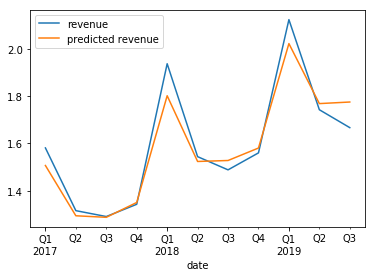

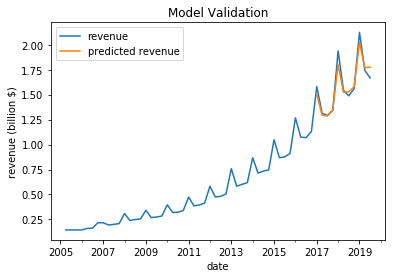

In [7]:
stepwise_model = auto_arima(rev,
                            start_p=1,
                            start_q=1,
                            max_p=5,
                            max_q=5,
                            m=20,
                            start_P=0,
                            seasonal=True,
                            error_action='ignore',
                            supress_warnings=True,
                            stepwise=True)

print(f'AIC for the best model {stepwise_model.aic()}')
   
test, train = np.split(data_cleaned, [int(0.2*len(data_cleaned))])
    
test = test.sort_values(by='date')\
           .set_index('date')
train = train.sort_values(by='date')\
             .set_index('date')
      
stepwise_model.fit(train)
      
forecast = stepwise_model.predict(n_periods=test.shape[0])
print(f'forecast for validation is {forecast}')
      
future_forecast = pd.DataFrame(forecast, 
                               index=test.index, 
                               columns=['predicted revenue'])
      
pd.concat([test, future_forecast],axis=1).plot()
pd.concat([rev,future_forecast],axis=1).plot()
plt.ylabel('revenue (billion $)')
plt.title('Model Validation')

prediction = pd.concat([test, future_forecast],axis=1)
mse = np.mean((prediction['revenue']-prediction['predicted revenue'])**2)
print(f'the MSE for the model based on test data is {mse}')

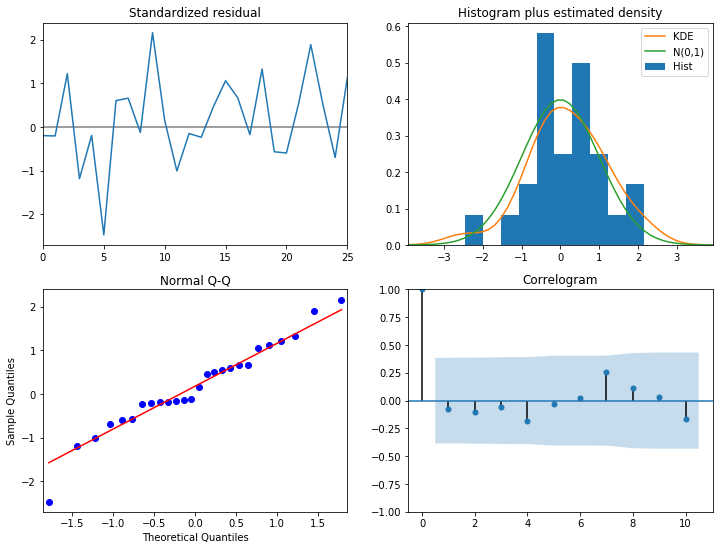

In [8]:
stepwise_model.plot_diagnostics(figsize=(12, 9))
plt.show()

## Step 4: Forecast Revenue
___

So far, we have managed to pick the best ARIMA model following the first three steps. In order to make use of every data points possible, we just need to re-fit the best ARIMA model with the full data set. We can finally make some real forecasting. 

In the first graph below, the orange curve represents my final prediction for the revenue of the next five quarters of ULTA. Just by eyeballing the result, we can see that the prediction looks reasonable. It not only follows the cycle, but also follows the previous trend. 

The final results of my prediction for UTLA's next five quarters' revenue would be 

|   Date   |      Revenue      |
|----------|-------------------|
|2019 Q4 |\$ 1.751444 Billion|
|2020 Q1 |\$ 2.361635 Billion|
|2020 Q2 |\$ 1.958330 Billion|
|2020 Q3 |\$ 1.873290 Billion|
|2020 Q4 |\$ 1.984946 Billion|

Text(0.5, 0, 'date')

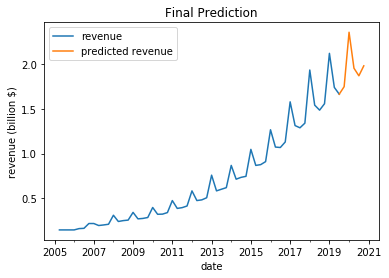

In [9]:
# re-train the ARIMA model based on the entire dataset 
stepwise_model.fit(rev)

# predict the next 5 quarters' revenue for ULTA in real condition
forecast_next = stepwise_model.predict(5)
forecast_next = pd.DataFrame(forecast_next, 
                             index=[date(year=2019, month=10, day=31),
                                    date(year=2020, month=1, day=31),
                                    date(year=2020, month=4, day=30),
                                    date(year=2020, month=7, day=31),
                                    date(year=2020, month=10, day=31)], 
                             columns=['predicted revenue'])

final_df = pd.concat([rev,forecast_next],axis=1)
final_df.loc[final_df.index=='2019-7-31']['predicted revenue'] = final_df.loc[final_df.index=='2019-7-31']['revenue']
final_df.loc['2019-7-31', 'predicted revenue'] = final_df.loc['2019-7-31', 'revenue']
final_df.plot()
plt.title('Final Prediction')
plt.ylabel('revenue (billion $)')
plt.xlabel('date')

In [10]:
# final prediction 
forecast_next

,predicted revenue
2019-10-31,1.751444
2020-01-31,2.361635
2020-04-30,1.958330
2020-07-31,1.873290
2020-10-31,1.984946
